In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

2022-06-03 23:55:48.627927: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
EPOCHS = 50
INIT_LR = 1e-1
BS = 256

In [3]:
from tensorflow.keras.datasets import mnist

def load_mnist_dataset():
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels
    return (data, labels)

In [4]:
import numpy as np

def load_az_dataset(datasetPath):
    data = []
    labels = []
    for row in open(datasetPath):
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        image = image.reshape((28, 28))
        data.append(image)
        labels.append(label)
    data = np.array(data, dtype='float32')
    labels = np.array(labels, dtype="int")
    return (data, labels)

In [5]:
(digitsData, digitsLabels) = load_mnist_dataset()

(azData, azLabels) = load_az_dataset('A_Z Handwritten Data.csv')

In [6]:
digitsData[0].shape

(28, 28)

In [7]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
azLabels += 10
# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [8]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
# Data Augmentation
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest")

In [10]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


In [11]:
class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data

        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
        momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
        kernel_regularizer=l2(reg))(act1)

        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
            padding="same", use_bias=False,
            kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
            kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                use_bias=False, kernel_regularizer=l2(reg))(act1)
        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x
    
    @staticmethod
    def build(width, height, depth, classes, stages, filters,
        reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(inputs)

        # check if we are utilizing the CIFAR dataset
        if dataset == "cifar":
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias=False,
            padding="same", kernel_regularizer=l2(reg))(x)

        # check to see if we are using the Tiny ImageNet dataset
        elif dataset == "tiny_imagenet":
            # apply CONV => BN => ACT => POOL to reduce spatial size
            x = Conv2D(filters[0], (5, 5), use_bias=False,
                padding="same", kernel_regularizer=l2(reg))(x)
            x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(x)
            x = Activation("relu")(x)
            x = ZeroPadding2D((1, 1))(x)
            x = MaxPooling2D((3, 3), strides=(2, 2))(x)
        
        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
            
            # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model

In [12]:
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
    (32, 32, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


2022-06-03 23:57:21.659987: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-03 23:57:21.664987: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-03 23:57:21.723585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-03 23:57:21.724129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 980 Ti computeCapability: 5.2
coreClock: 1.2405GHz coreCount: 22 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 313.37GiB/s
2022-06-03 23:57:21.724147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-06-03 23:57:21.735420: I tensorflow/stream_executor/platform

In [13]:
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...
Epoch 1/50


2022-06-03 23:57:31.199650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-03 23:57:31.218467: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz
2022-06-03 23:57:32.778215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-03 23:57:33.213173: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-06-03 23:57:33.219161: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1382/1382 [==============================] - 140s 98ms/step - loss: 4.9214 - accuracy: 0.7082 - val_loss: 0.4892 - val_accuracy: 0.9050
Epoch 2/50
1382/1382 [==============================] - 136s 98ms/step - loss: 0.9764 - accuracy: 0.9233 - val_loss: 0.6241 - val_accuracy: 0.8509
Epoch 3/50
1382/1382 [==============================] - 137s 99ms/step - loss: 0.8570 - accuracy: 0.9344 - val_loss: 0.5427 - val_accuracy: 0.8786
Epoch 4/50
1382/1382 [==============================] - 136s 99ms/step - loss: 0.8093 - accuracy: 0.9374 - val_loss: 0.5921 - val_accuracy: 0.8540
Epoch 5/50
1382/1382 [==============================] - 136s 98ms/step - loss: 0.7814 - accuracy: 0.9387 - val_loss: 0.5173 - val_accuracy: 0.8892
Epoch 6/50
1382/1382 [==============================] - 136s 98ms/step - loss: 0.7515 - accuracy: 0.9425 - val_loss: 0.5146 - val_accuracy: 0.8875
Epoch 7/50
1382/1382 [==============================] - 136s 98ms/step - loss: 0.7260 - accuracy: 0.9439 - val_loss: 0.5619 - val

In [14]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.73      0.40      0.52      1381
           1       0.98      0.99      0.99      1575
           2       0.96      0.95      0.95      1398
           3       0.99      0.99      0.99      1428
           4       0.94      0.98      0.96      1365
           5       0.84      0.92      0.88      1263
           6       0.96      0.99      0.97      1375
           7       0.98      0.99      0.99      1459
           8       0.97      0.99      0.98      1365
           9       1.00      0.98      0.99      1392
           A       1.00      0.99      0.99      2774
           B       0.98      0.99      0.99      1734
           C       0.99      0.99      0.99      4682
           D       0.89      0.99      0.94      2027
           E       0.99      0.99      0.99      2288
           F       0.96      0.99      0.97       232
           G       0.98      0.96      0.97      115

In [15]:
model.save("ocr_recognition.h5")

In [16]:
model.save_weights("weight")

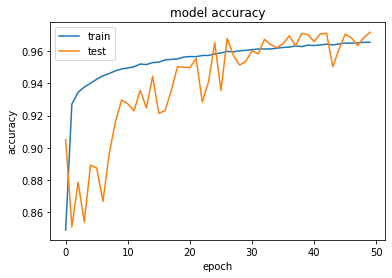

In [17]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

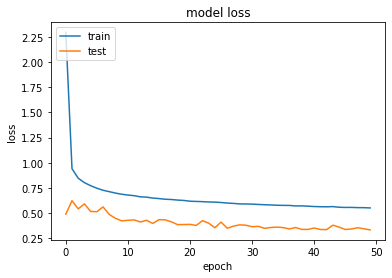

In [18]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
# from google.colab.patches import cv2_imshow

In [22]:
def predict_image(img):
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    chars = []

    for c in cnts:
      # compute the bounding box of the contour
      (x, y, w, h) = cv2.boundingRect(c)
      # filter out bounding boxes, ensuring they are neither too small
      # nor too large
      if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
      # extract the character and threshold it to make the character
      # appear as *white* (foreground) on a *black* background, then
      # grab the width and height of the thresholded image
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
          cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        # if the width is greater than the height, resize along the
        # width dimension
      if tW > tH:
        thresh = imutils.resize(thresh, width=32)
      # otherwise, resize along the height
      else:
        thresh = imutils.resize(thresh, height=32)
      
      (tH, tW) = thresh.shape
      dX = int(max(0, 32 - tW) / 2.0)
      dY = int(max(0, 32 - tH) / 2.0)
      # pad the image and force 32x32 dimensions
      padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,value=(0, 0, 0))
      padded = cv2.resize(padded, (32, 32))
      padded = padded.astype("float32")
      padded = np.expand_dims(padded, axis=-1)
      chars.append((padded, (x, y, w, h)))
      plt.imshow(padded)
      boxes = [b[1] for b in chars]
      #cv2_imshow(chars)
      chars = np.array([c[0] for c in chars], dtype="float32")
      # OCR the characters using our handwriting recognition model
      preds = model.predict(chars)
      # define the list of label names
      labelNames = "0123456789"
      labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
      labelNames = [l for l in labelNames]
      output=""
      for (pred, (x, y, w, h)) in zip(preds, boxes):
        i = np.argmax(pred)
        prob = pred[i]
        label = labelNames[i]
        output+=label
  
      return output

In [42]:
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
img=cv2.imread("test4.png",cv2.IMREAD_GRAYSCALE)
img=cv2.resize(img,(32,32))
padded = img.astype("float32")/255
padded = img.reshape((1,32,32,1))
prediction=model.predict(padded)
print(prediction)
labelNames[np.argmax(prediction)]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


'F'